In [ ]:
# !pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import joblib
import utils # contient toutes les fonctions crees pour le projet..


from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

### Importation des donnees


In [ ]:
# ROOT = "/content/drive/Shareddrives/Canvas ECo energy/Eco Energy Energy Live Capstone/datasets/" # chemin sur colab
ROOT = "C:/Users/georg/OneDrive/Documents/GitHub/CapstoneProjectEnergy/Dataset/" # chemin en local


dred = "DRED.csv"
qud = "QUD.csv"
sim = "SimDataset.csv"


rw_dred = pd.read_csv(ROOT+dred, names= ["occupancy", "P", "Pn", "P+t1", "P-t1","class_state"], header=None)
rw_qud = pd.read_csv(ROOT+qud, names= ["occupancy", "P", "Pn", "P+t1", "P-t1","class_state"], header=None)
rw_sim = pd.read_csv(ROOT+sim, names= ['Occupancy' , 'Appliance_ID' , 'Sin(time)' , 'Cos(time)' , 'Sin(day)' , 'Cos(day)' , 'Power_consumption_P(t)' , 'Normalized-power-consumption ' , 'P(t)-P(t+1)' , 'P(t)-P(t-1)' , 'Micro-moment_class'], header=None)



In [ ]:
print(rw_dred.shape)
rw_dred.head()

In [ ]:
print(rw_qud.shape)
rw_qud.head()

## Machine Learning

In [ ]:
# !pip install xgboost

#### Normalisation avec le coefficient de variance pour le ML

Qud

In [ ]:
rw_qud.shape , rw_qud.shape[0]-3
input_qud, output_qud = utils.slide_window(dataset=rw_qud ,window_size=3)
input_qud = input_qud.squeeze()

new_qud_dataset = np.concatenate((input_qud, np.expand_dims(output_qud, axis=-1)) , axis = 1)

df_qud = pd.DataFrame(new_qud_dataset, columns = ['oc1','oc2','oc3','p1','p2','p3','pt01','pt02','pt03' ,'pt11','pt22','pt33' ,'cl1','cl2','cl3', 'out' ] )

## normalisons avec le coefficient de variance

df_qud['mean'] = (df_qud['p1'] + df_qud['p2'] + df_qud['p3'] ) / 3 # moyenne des valeurs power pour une window
df_qud['std_window'] = df_qud[['p1' , 'p2' , 'p3']].std(axis=1) # std de P1, P2, P3
df_qud['norm_window'] = ( df_qud['std_window']/(df_qud['mean'] + 1e-7) ) * ((df_qud[['p1' , 'p2' , 'p3']].max(axis=1) - df_qud[['p1' , 'p2' , 'p3']].min(axis=1)) /1000) # normalization de P1, P2, P3 

## visualisation

debut = 0
fin   = -1

plt.plot(df_qud['p2'][debut:fin])
plt.xlabel('Timestep')
plt.ylabel("Puissance originale")
plt.title("Power dans chaque fenetre" , {'fontsize': 9}  )
plt.show()
print()

plt.plot(df_qud['norm_window'][debut:fin])
plt.xlabel('Timestep')
plt.ylabel("Power normalisee")
plt.title("Power normalisee (w) dans chaque fenetre" , {'fontsize': 9}  )
plt.show()
print()


df_qud.head()

In [ ]:
# quelques statistiques

df_qud.describe()

In [ ]:
qud_corr = df_qud.corr()
sns.heatmap(qud_corr)
qud_corr

Dred

In [ ]:
rw_dred.shape , rw_dred.shape[0]-3
input_dred, output_dred = utils.slide_window(dataset=rw_dred ,window_size=3)
input_dred = input_dred.squeeze()

new_dred_dataset = np.concatenate((input_dred, np.expand_dims(output_dred, axis=-1)) , axis = 1)

df_dred = pd.DataFrame(new_dred_dataset, columns = ['oc1','oc2','oc3','p1','p2','p3','pt01','pt02','pt03' ,'pt11','pt22','pt33' ,'cl1','cl2','cl3', 'out' ] )

## normalisaons avec le coefficient de variance

df_dred['mean'] = (df_dred['p1'] + df_dred['p2'] + df_dred['p3'] ) / 3 # moyenne des valeurs power pour une window
df_dred['std_window'] = df_dred[['p1' , 'p2' , 'p3']].std(axis=1) # std de P1, P2, P3
df_dred['norm_window'] = ( df_dred['std_window']/(df_dred['mean'] + 1e-7 ) ) * ((df_dred[['p1' , 'p2' , 'p3']].max(axis=1) - df_dred[['p1' , 'p2' , 'p3']].min(axis=1)) /1000) # normalization de P1, P2, P3 

## visualisation

debut = 0
fin   = -1

plt.plot(df_dred['p2'][debut:fin])
plt.xlabel('Timestep')
plt.ylabel("Power normalisee")
plt.title("Power dans chaque fenetre" , {'fontsize': 9}  )
plt.show()
print()

plt.plot(df_dred['norm_window'][debut:fin])
plt.xlabel('Timestep')
plt.ylabel("Power normalisee")
plt.title("Power normalisee (w) dans chaque fenetre" , {'fontsize': 9}  )
plt.show()
print()


df_dred.head(5)

In [ ]:
# quelques statistiques

df_dred.describe()

In [ ]:
dred_corr = df_dred.corr()
sns.heatmap(dred_corr)
df_dred.head(20)

Models

In [ ]:
# Separation en train et test

# dred
dred_feature = df_dred.iloc[ : , 1:-3 ].drop( 'out' , axis = 1 )
dred_target  = df_dred.iloc[ : , 1:-3 ].out

dred_features_train = dred_feature.iloc[ : int(dred_feature.shape[0]*0.8 ) , : ]
dred_features_test  = dred_feature.iloc[ int(dred_feature.shape[0]*0.8 ) : , : ]  

dred_target_train = dred_target.iloc[ : int(dred_feature.shape[0]*0.8 ) ]
dred_target_test  = dred_target.iloc[ int(dred_feature.shape[0]*0.8 ) : ]  




# qud
qud_feature = df_qud.iloc[ : , 1:-3 ].drop( 'out' , axis = 1 )
qud_target  = df_qud.iloc[ : , 1:-3 ].out

qud_features_train = qud_feature.iloc[ : int(qud_feature.shape[0]*0.8 ) , : ]
qud_features_test  = qud_feature.iloc[ int(qud_feature.shape[0]*0.8 ) : , : ]  

qud_target_train = qud_target.iloc[ : int(qud_feature.shape[0]*0.8 ) ]
qud_target_test  = qud_target.iloc[ int(qud_feature.shape[0]*0.8 ) : ]  



In [ ]:
# qud
score_qud_cov = {}

xgb_baseline_qud = XGBClassifier()


xgb_baseline_qud.fit(qud_features_train, qud_target_train)
yhat = xgb_baseline_qud.predict(qud_features_test)

score_qud_cov['micro'] =  f1_score(qud_target_test, yhat, average = None)
print(f"Les scores de chaque classe: \n{score_qud_cov['micro']}")

print()
score_qud_cov['macro'] = f1_score(qud_target_test, yhat, average = "macro")
print(f"Les scores de ENSEMBLE classe: \n{score_qud_cov['macro']}")

In [ ]:
# dred
score_dred_cov = {}

xgb_baseline_dred = XGBClassifier()


xgb_baseline_dred.fit(dred_features_train, dred_target_train)
yhat = xgb_baseline_dred.predict(dred_features_test)

score_dred_cov['micro'] =  f1_score(dred_target_test, yhat, average = None)
print(f"Les scores de chaque classe: \n{score_dred_cov['micro']}")

print()
score_dred_cov['macro'] = f1_score(dred_target_test, yhat, average = "macro")
print(f"Les scores de ENSEMBLE classe: \n{score_dred_cov['macro']}")

### Normalisation avec le stateful pour le ML

In [ ]:
# drop de la colonne de la "power normalized"

dred_dropped = rw_dred.drop('Pn', axis=1)
qud_dropped  = rw_qud.drop('Pn', axis=1)

print(dred_dropped.head())
print()
print(qud_dropped.head())

In [ ]:
np.set_printoptions(precision=25, suppress=True)
processor = utils.DataProcessing(qud_dropped)
X_qud , y_qud = processor.processing()

In [ ]:
processor = utils.DataProcessing(dred_dropped)
X_dred , y_dred = processor.processing()

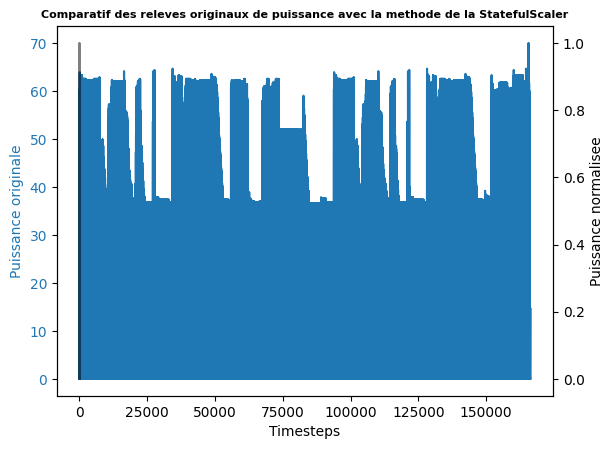

In [24]:
# visuel comparatif (superpose)

debut = 0
fin   = -1

# Creating plot with dataset_1
fig, ax1 = plt.subplots()
 
color = 'tab:blue'
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Puissance originale', color = color)
ax1.plot(df_dred['p2'][debut:fin], color = color)
ax1.tick_params(axis ='y', labelcolor = color)
 
# Adding Twin Axes to plot using dataset_2
ax2 = ax1.twinx()
 
# color = 'tab:green'
ax2.set_ylabel('Puissance normalisee', color = 'black')
ax2.plot(X_dred[debut:fin][4], color = 'black', alpha = 0.5)
ax2.tick_params(axis ='y', labelcolor = 'black')
 
# Adding title
plt.title('Comparatif des releves originaux de puissance avec la methode de la StatefulScaler', fontsize = 8, fontweight ="bold")
 
# Show plot
plt.show()# Creating plot with dataset_1

Models

In [ ]:
# Modele de qud

score_qud_sc = {}

xgb_sf = XGBClassifier()


xgb_sf.fit(qud_features_train_sf, qud_target_train_sf)
yhat = xgb_sf.predict(qud_features_test_sf)


score_qud_sc['micro'] =  f1_score(qud_target_test_sf, yhat, average = None)
print(f"Les scores de chaque classe: \n{score_qud_sc['micro']}")

print()
score_qud_sc['macro'] = f1_score(qud_target_test_sf, yhat, average = "macro")
print(f"Les scores de ENSEMBLE classe: \n{score_qud_sc['macro']}")

In [ ]:
# Modele de dred

score_dred_sc = {}

xgb_sf = XGBClassifier()


xgb_sf.fit(dred_features_train_sf, dred_target_train_sf)
yhat = xgb_sf.predict(dred_features_test_sf)


score_dred_sc['micro'] =  f1_score(dred_target_test_sf, yhat, average = None)
print(f"Les scores de chaque classe: \n{score_dred_sc['micro']}")

print()
score_dred_sc['macro'] = f1_score(dred_target_test_sf, yhat, average = "macro")
print(f"Les scores de ENSEMBLE classe: \n{score_dred_sc['macro']}")

### Les scores

In [28]:
# Les scores avec la technique du coef de covariance

print(f"DRED  ==> {score_dred_cov}")
print(f"QUD   ==> {score_qud_cov}")

DRED  ==> {'micro': array([0.5650479129446159  , 0.9939301972685888  , 0.032210834553440704,
       0.4658136745301879  , 0.5015364559083713  ]), 'macro': 0.5117078150410409}
QUD   ==> {'micro': array([0.9594662638469285, 0.9903846153846153, 0.9905660377358491,
       0.857685009487666 , 0.9815013404825736]), 'macro': 0.9559206533875264}


In [29]:
# Les scores avec la technique Statefulscaler

print(f"DRED  ==> {score_dred_sc}")
print(f"QUD   ==> {score_qud_sc}")

DRED  ==> {'micro': array([0.4767511474755538 , 0.9886792452830189 , 0.                 ,
       0.32877919788453064, 0.5811226998628329 ]), 'macro': 0.4750664581011873}
QUD   ==> {'micro': array([0.9448335176311585, 0.9809523809523809, 0.                ,
       0.8404408241494968, 0.9643092321875412]), 'macro': 0.7461071909841155}


### Sauvegarde du meilleur model en ML

In [30]:
# avec pickle

path = "C:/Users/georg/OneDrive/Documents/GitHub/CapstoneProjectEnergy/"

filename1 = path + 'Models/baseline_qud1_model.sav'
pickle.dump(xgb_baseline_dred, open(filename1, 'wb'))
print(filename1)

# avec joblib

filename2 = path + 'Models/baseline_dred1_model.sav'
joblib.dump(xgb_baseline_qud, filename2)
print(filename2)

C:/Users/georg/OneDrive/Documents/GitHub/CapstoneProjectEnergy/Models/baseline_qud1_model.sav
C:/Users/georg/OneDrive/Documents/GitHub/CapstoneProjectEnergy/Models/baseline_dred1_model.sav


## Deep Machine Learning

In [ ]:
def create_model(input_shape, output_shape):

  input  = tf.keras.Input( shape = input_shape )
  output = tf.keras.layers.Dense( 128 , activation = "relu" )( input )
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( input )
  lstm   = tf.keras.layers.LSTM(256)( output ) 
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( lstm )
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( output )
  output = tf.keras.layers.Dense(  5  , activation = "softmax" )( output )

  model = tf.keras.Model( inputs= input , outputs= output )

  return model

model = create_model( 
    input_shape = (3, 4), # 3 lectures pour 4 features chacune
    output_shape = 2
 )
model.summary()

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = "categorical_crossentropy",
    metrics = [utils.get_f1, 'accuracy']
)

In [ ]:
# donnees
## l'on retire la colonne Pn avant de le passer au Generateur

rw_dred_cleaned = rw_dred.drop(['Pn'] , axis=1)
rw_qud_cleaned  = rw_qud.drop(['Pn'] , axis=1)
# print(rw_dred_cleaned.shape)

## dred
dred_train = rw_dred_cleaned[:int(rw_dred_cleaned.shape[0]*0.8)]
dred_test = rw_dred_cleaned[int(rw_dred_cleaned.shape[0]*0.8):]
print(dred_train.head())

## qud
qud_train = rw_qud_cleaned[:int(rw_qud_cleaned.shape[0]*0.8)]
qud_test = rw_qud_cleaned[int(rw_qud_cleaned.shape[0]*0.8):]
print(qud_train.head())

### Avec le StatefulScaler

In [32]:
def create_model(input_shape, output_shape):

  input  = tf.keras.Input( shape = input_shape )
  output = tf.keras.layers.Dense( 128 , activation = "relu" )( input )
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( input )
  lstm   = tf.keras.layers.LSTM(256)( output ) 
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( lstm )
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( output )
  output = tf.keras.layers.Dense(  5  , activation = "softmax" )( output )

  model = tf.keras.Model( inputs= input , outputs= output )

  return model

model_qud_sc = create_model( 
    input_shape = (3, 5), # 3 lectures pour 4 features chacune
    output_shape = 2
 )
model_qud_sc.summary()

print()

model_dred_sc = create_model( 
    input_shape = (3, 5), # 3 lectures pour 4 features chacune
    output_shape = 2
 )
model_dred_sc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 5)]            0         
                                                                 
 dense_1 (Dense)             (None, 3, 256)            1536      
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 659,717
Trainable params: 659,717
Non-trainable

In [33]:
model_qud_sc.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = "categorical_crossentropy",
    metrics = [utils.get_f1, 'accuracy']
)

model_dred_sc.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = "categorical_crossentropy",
    metrics = [utils.get_f1, 'accuracy']
)

In [ ]:
#dred

generateur_train = utils.Generateur_sc(dred_train, window_size=3, batch_size=256)
generateur_test = utils.Generateur_sc(dred_test, window_size=3, batch_size=256)

# print((generateur_train[0]))
dred_hist_sc = model_dred_sc.fit(
    x = generateur_train,
    epochs=10,
    validation_data = generateur_test
)

In [ ]:
#qud

generateur_train = utils.Generateur_sc(qud_train, window_size=3, batch_size=256)
generateur_test = utils.Generateur_sc(qud_test, window_size=3, batch_size=256)

# print((generateur_train[0]))
qud_hist_sc = model_qud_sc.fit(
    x = generateur_train,
    epochs=10,
    validation_data = generateur_test
)

In [36]:
# Les scores avec la technique du stateful scaler

dred_score_sc = np.max(dred_hist_sc.history["val_get_f1"])
qud_score_sc  = np.max(qud_hist_sc.history["val_get_f1"])

print(f"DRED  ==> {dred_score_sc}")
print(f"QUD   ==> {qud_score_sc}")

DRED  ==> 0.9002543091773987
QUD   ==> 0.8160226941108704


### Avec le Coef de variance

In [37]:
def create_model(input_shape, output_shape):

  input  = tf.keras.Input( shape = input_shape )
  output = tf.keras.layers.Dense( 128 , activation = "relu" )( input )
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( input )
  lstm   = tf.keras.layers.LSTM(256)( output ) 
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( lstm )
  output = tf.keras.layers.Dense( 256 , activation = "relu" )( output )
  output = tf.keras.layers.Dense(  5  , activation = "softmax" )( output )

  model = tf.keras.Model( inputs= input , outputs= output )

  return model

model_qud_cv = create_model( 
    input_shape = (1, 5), # 3 lectures pour 4 features chacune
    output_shape = 2
 )
model_qud_cv.summary()

print()

model_dred_cv = create_model( 
    input_shape = (1, 5), # 3 lectures pour 4 features chacune
    output_shape = 2
 )
model_dred_cv.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 5)]            0         
                                                                 
 dense_11 (Dense)            (None, 1, 256)            1536      
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dense_14 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 659,717
Trainable params: 659,717
Non-trainab

In [38]:
model_qud_cv.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = "categorical_crossentropy",
    metrics = [utils.get_f1, 'accuracy']
)
model_dred_cv.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = "categorical_crossentropy",
    metrics = [utils.get_f1, 'accuracy']
)

In [39]:
#dred

generateur_train = utils.Generateur_cv(dred_train, window_size=3, batch_size=256)
generateur_test = utils.Generateur_cv(dred_test, window_size=3, batch_size=256)

# print((generateur_train[0]))
dred_hist_cv = model_dred_cv.fit(
    x = generateur_train,
    epochs=10,
    validation_data = generateur_test
)

Epoch 1/10
519/519 [==============================] - 47s 81ms/step - loss: 0.5974 - get_f1: 0.7540 - accuracy: 0.7935 - val_loss: 0.5329 - val_get_f1: 0.7253 - val_accuracy: 0.8907
Epoch 2/10
519/519 [==============================] - 42s 80ms/step - loss: 0.4291 - get_f1: 0.8805 - accuracy: 0.8827 - val_loss: 0.4123 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 3/10
519/519 [==============================] - 44s 84ms/step - loss: 0.4114 - get_f1: 0.8860 - accuracy: 0.8869 - val_loss: 0.4390 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 4/10
519/519 [==============================] - 43s 83ms/step - loss: 0.4230 - get_f1: 0.8845 - accuracy: 0.8849 - val_loss: 0.4042 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 5/10
519/519 [==============================] - 44s 85ms/step - loss: 0.4089 - get_f1: 0.8840 - accuracy: 0.8860 - val_loss: 0.4035 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 6/10
519/519 [==============================] - 42s 81ms/step - loss: 0.4091 - get_f

In [40]:
#qud

generateur_train = utils.Generateur_cv(dred_train, window_size=3, batch_size=256)
generateur_test = utils.Generateur_cv(dred_test, window_size=3, batch_size=256)

# print((generateur_train[0]))
qud_hist_cv = model_qud_cv.fit(
    x = generateur_train,
    epochs=10,
    validation_data = generateur_test
)

Epoch 1/10
519/519 [==============================] - 47s 82ms/step - loss: 0.6164 - get_f1: 0.7589 - accuracy: 0.7984 - val_loss: 0.4483 - val_get_f1: 0.8997 - val_accuracy: 0.9003
Epoch 2/10
519/519 [==============================] - 41s 79ms/step - loss: 0.4312 - get_f1: 0.8803 - accuracy: 0.8821 - val_loss: 0.4244 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 3/10
519/519 [==============================] - 43s 82ms/step - loss: 0.4205 - get_f1: 0.8855 - accuracy: 0.8856 - val_loss: 0.4589 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 4/10
519/519 [==============================] - 42s 81ms/step - loss: 0.4194 - get_f1: 0.8839 - accuracy: 0.8839 - val_loss: 0.4006 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 5/10
519/519 [==============================] - 43s 83ms/step - loss: 0.4109 - get_f1: 0.8855 - accuracy: 0.8857 - val_loss: 0.4093 - val_get_f1: 0.9003 - val_accuracy: 0.9003
Epoch 6/10
519/519 [==============================] - 42s 81ms/step - loss: 0.4061 - get_f

In [41]:
# Les scores avec la technique du coef de covariance

dred_score_cv = np.max(dred_hist_cv.history["val_get_f1"])
qud_score_cv  = np.max(qud_hist_cv.history["val_get_f1"])

print(f"DRED  ==> {dred_score_cv}")
print(f"QUD   ==> {qud_score_cv}")

DRED  ==> 0.9002543091773987
QUD   ==> 0.9002543091773987


In [42]:
# Les best epochs avec la technique du coef de covariance

dred_score_cv = np.argmax(dred_hist_cv.history["val_get_f1"])
qud_score_cv  = np.argmax(qud_hist_cv.history["val_get_f1"])

print(f"DRED  ==> {dred_score_cv}")
print(f"QUD   ==> {qud_score_cv}")

DRED  ==> 1
QUD   ==> 1


### Scores en DML

In [43]:
# Les scores avec la technique du stateful scaler

dred_score_sc = np.max(dred_hist_sc.history["val_get_f1"])
qud_score_sc  = np.max(qud_hist_sc.history["val_get_f1"])

print(f"DRED  ==> {dred_score_sc}")
print(f"QUD   ==> {qud_score_sc}")

DRED  ==> 0.9002543091773987
QUD   ==> 0.8160226941108704


In [44]:
# Les scores avec la technique du coef de covariance

dred_score_cv = np.max(dred_hist_cv.history["val_get_f1"])
qud_score_cv  = np.max(qud_hist_cv.history["val_get_f1"])

print(f"DRED  ==> {dred_score_cv}")
print(f"QUD   ==> {qud_score_cv}")

DRED  ==> 0.9002543091773987
QUD   ==> 0.9002543091773987
